# Analytical solution to a 1D FLD problem

Credit for providing the solution and the setup goes to Alex Ziampras. Thanks, Alex!

$$\Sigma c_v \frac{\partial T}{\partial t} = -\nabla\cdot\vec{F}, \qquad \vec{F} = -\lambda\frac{16\sigma T^3}{\kappa\rho} \nabla T$$

$$\nabla\cdot\vec{F} = 0 \Rightarrow \nabla \cdot \left[\frac{T^3}{\rho} \nabla T\right] = 0$$

cylindrical: $$\frac{1}{R}\frac{\partial}{\partial R}\left(\frac{T^3 H}{\Sigma} R \frac{\partial T}{\partial R}\right) = 0\qquad(\rho\propto \Sigma/H)$$

$H\propto \sqrt{R^3 T}$, $\Sigma\propto R^{-1/2}$:
$$\frac{\partial}{\partial R}\left(\frac{T^3 R^{3/2} T^{1/2}}{R^{-1/2}} R \frac{\partial T}{\partial R}\right) = 0$$

$$\frac{\partial}{\partial R}\left(T^{7/2} R^3 \frac{\partial T}{\partial R}\right) = 0$$

$$T^{7/2} R^3 \frac{\partial T}{\partial R} = c_1$$

$$T^{7/2} dT = c_1 \frac{dR}{R^3}$$

$$T^{9/2} = c_1 \frac{1}{R^2} + c_2$$

$$T = \left(c_1 R^{-2} + c_2\right)^{2/9}$$

$T(R_\mathrm{min}) = T_\mathrm{min}$, $T(R_\mathrm{max}) = T_\mathrm{max}$

define $T_1 = T_\mathrm{min}^{9/2}$, $T_2 = T_\mathrm{max}^{9/2}$, $R_1 = R_\mathrm{min}^{-2}$, $R_2 = R_\mathrm{max}^{-2}$

then $$c_1 = \frac{T_2 - T_1}{R_2-R_1}\qquad c_2 = \frac{R_2 T_1 - R_1 T_2}{R_2-R_1}$$

In [3]:
import numpy as np

def calc_theo(R):
    
    mu = 2.353
    K = 106701.29 # code unit for temperature
    T0 = mu * 0.05**2 * K


    f1, f2 = -3.5, 5 # old module
    f1, f2 = -2, 9/2 # new module

    Rmin = R[0]
    Rmax = R[-1]

    R1 = Rmin ** f1
    R2 = Rmax ** f1
    T1 = (T0 / Rmin)**f2
    T2 = (T0 / Rmax)**f2
    c1 = (T2-T1) / (R2-R1)
    c2 = (R2*T1 - R1*T2) / (R2-R1)
    T = (c1 * R ** f1 + c2) ** (1/f2)

    from types import SimpleNamespace

    theo = SimpleNamespace()
    theo.R = R
    theo.T = T
    theo.T0 = T0
    return theo

Calculate the radial flux to check if the divergence is close to zero.
This is equivalent to checking that $$R \frac{T^3}{\rho} \nabla T = \text{const.}$$

In [4]:
def calc_flux(R, T):
    # R**1.5 = 1/rho = H/Sigma
    H = np.sqrt(T*R**3)
    sig = R ** -0.5
    rho = sig/H
    return T**3 / rho * np.gradient(T, R)

## Plot data

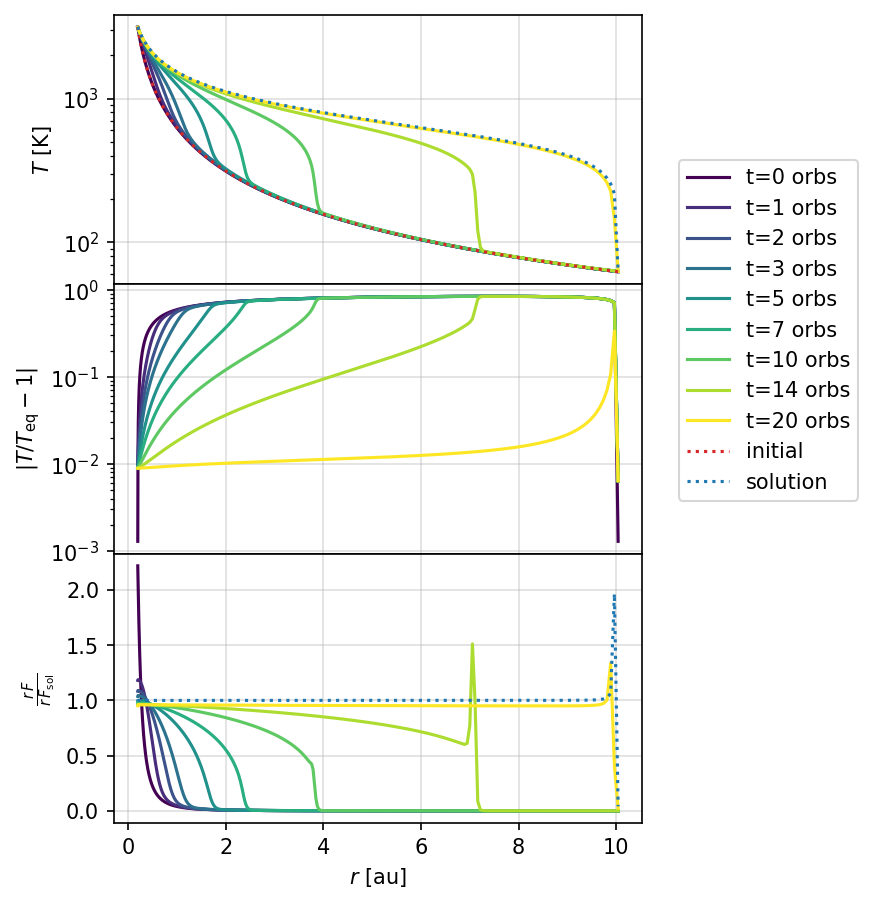

In [7]:


# Calculate the radial flux to check if the divergence is close to zero.
# This is equivalent to checking that $$R \frac{T^3}{\rho} \nabla T = \text{const.}$$

def calc_flux(R, T):
    # R**1.5 = 1/rho = H/Sigma
    H = np.sqrt(T*R**3)
    sig = R ** -0.5
    rho = sig/H
    return T**3 / rho * np.gradient(T, R)

###
### Plot data
###

import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=3, ncols=2, width_ratios=[5,1], dpi=150, figsize=(6,7), sharex="all")
empty_axes = axes[:,1]
for ax in empty_axes:
    ax.axis("off")
    # ax.get_xaxis().set_visible(False)
    # ax.get_yaxis().set_visible(False)
axes = axes[:,0]
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.00)



from fargocpt import Loader
l = Loader("../../output/tests/FLD1D/out/")

dataunit = "J/cm2"

Nfirst = l.snapshots[0]
Nlast = l.snapshots[-1]

r, profile0 = l.gas.vars2D.avg("Temperature", Nfirst)
profile0 = profile0.to_value("K")
r = r.to_value("au")

theo = calc_theo(r)

# normalization value for flux
n = np.argmin(np.abs(theo.R - 1))
R0 = theo.R[n]
F0 = calc_flux(r, theo.T)[n]


from matplotlib import colormaps
cmap = colormaps.get_cmap("viridis")



inds = np.geomspace(np.min(1,Nfirst), Nlast, 10, dtype=int)
# inds = [0, 1, 3, 5, 8, 10, 20, 30, 50, 75, 100, Nlast]
inds = np.append([Nfirst], inds)
inds = np.unique(inds)
for k, n in enumerate(inds):
    color = cmap(k/(len(inds)-1))
    
    try:
        T = l.gas.vars2D.avg("Temperature", n, grid=False)
    except FileNotFoundError:
        continue

    y = T.to_value("K")
    
    t = l.snapshot_time[n].to_value("yr")/1**1.5
    line, = axes[0].plot(r, y, label=f"t={t:.0f} orbs", color=color)
    axes[1].plot(r, np.abs((y/theo.T-1)), label=f"t={t:.3f}yr", color=color)

    ### Plot radial flux
    F = calc_flux(r, y)
    axes[2].plot(r, r*F / (R0*F0), label=f"t={t:.3f}yr", color=color)




### Plot theoretical data

axes[0].plot(theo.R, theo.T0 / theo.R, ls=":", label='initial', color="tab:red")
axes[0].plot(theo.R, theo.T, ls=":", label='solution', color="tab:blue")

### Plot radial flux
F = calc_flux(r, theo.T)
axes[2].plot(r, r*F / (R0*F0), ls=":", label='solution', color="tab:blue")



axes[0].legend(bbox_to_anchor=(1.05,0.5))

axes[0].set_ylabel('$T$ [K]')
axes[0].set_yscale('log')

axes[1].set_ylabel('$|T/T_\mathrm{eq} - 1|$')
axes[1].set_yscale('log')

axes[2].set_ylabel(r'$\frac{r\,F}{r\,F_\mathrm{sol}}$')

axes[-1].set_xlabel('$r$ [au]')
for ax in axes:
    ax.grid(alpha=0.4)

Could also plot radiative flux  $F_\text{rad} \propto \frac{T^3}{\rho} \nabla T$, this should be constant